$\textbf{This Notebook includes the following tasks}$:

$\bullet$ Web scrape cars.com

$\bullet$ ETL and EDA of the scraped data

$\bullet$ Gradient Boosting Tree Regression

$\bullet$ Bayesian Hyperparameter Optimization

$\bullet$ Model Explainability

# Required packages

In [ ]:
# for scraping
import requests
import time
from bs4 import BeautifulSoup
import json

# for ETL and EDA
from tqdm import tqdm
from copy import deepcopy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import joblib
# pip install "kaleido==0.2.1"
import kaleido
from warnings import filterwarnings
filterwarnings('ignore')


# prediction
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import RepeatedKFold
import optuna.integration.lightgbm as lgb
import optuna

# explainability
import shap
# print the JS visualization code to the notebook
shap.initjs()

# Cars.com Web Scraping

Here, we create the required functions to get the data from cars.com, then using these functions, we scrape all the cars in the first 50 pages that was manufactured in between 2005-2020 for random 50 ZIP CODES

In [ ]:
headers={"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"}
page = 1
zip = 75082
model = 'mercedes_benz'
year_max = 2020
year_min = 2015

def get_soup(page = page, zip = zip, model = model, year_max = year_max, year_min = year_min, headers = headers):
  website = "https://www.cars.com/shopping/results/?page={}&page_size=20&dealer_id=&keyword=&list_price_max=&list_price_min=&makes[]=".format(page) + model +"&maximum_distance=70&mileage_max=&sort=best_match_desc&stock_type=used&year_max={}&year_min={}&zip={}".format(year_max, year_min, zip)
  # get request
  response = requests.get(website, headers)
  # check if request is successful
  status = response.status_code
  if status == 200:
     # create soup object
     soup = BeautifulSoup(response.content, 'html.parser')
     # get results
     results = soup.find_all('div', {'class': 'vehicle-card'})
     return results
  else: 
    print('Request Rejected')
    return None

def get_data(results, row):
  outcome = results[row].find('div',{'class':'list-item-tooltip-container'})
  outcome = outcome.find('a',{'class':"sds-link"})
  outcome = json.loads(outcome.get('data-override-payload'))
  return outcome

def get_details_from_soup(results):
  cars = []
  for i in range(len(results)):
    car = {}
    # get main details
    try:
      details = get_data(results, i)
      car['type'] = details['bodystyle']
      car['model'] = details['model']
      car['make'] = details['make']  
      car['stock_type'] = details['stock_type']
      car['year'] = int(details['model_year'])
      car['price'] = details['price']
    except: 
      car['type'] = None
      car['model'] = None
      car['make'] = None
      car['stock_type'] = None
      car['year'] = None
      car['price'] = None
    
    # mileage
    try: 
      car['mileage'] = results[i].find('div',{'class':'mileage'}).get_text()
      car['mileage'] = int(car['mileage'][:-4].replace(",", ""))
    except: car['mileage'] = None
    # rating 
    try: car['rating'] = float(results[i].find('span',{'class':'sds-rating__count'}).get_text())
    except: car['rating'] = None
    # rating_count
    try: 
      car['rating_count'] = results[i].find('span',{'class':'sds-rating__link sds-button-link'}).get_text()
      car['rating_count'] = int(car['rating_count'].split()[0][1:].replace(',',''))
    except: car['rating_count'] = None
    cars.append(car)
  return cars

In [ ]:
model = 'audi'
results = get_soup(page = page, zip = zip, model = model, year_max = year_max, year_min = year_min, headers = headers)
if results:
   output = get_details_from_soup(results)
   print(f'Data scraped for {model} cars at ZIP-{zip} for page {page}')
output[0]

Data scraped for audi cars at ZIP-48895 for page 49


{'type': 'suv',
 'model': 'q5',
 'make': 'audi',
 'stock_type': 'used',
 'year': 2015,
 'price': 24990,
 'mileage': 57203,
 'rating': None,
 'rating_count': None}

In [ ]:
# get a sample of zip codes in the USA (I got this from a dataset that has a zip column)
ZIPS = list(set(pd.read_csv('SBA_loans_small.csv').sample(50).Zip.values))
len(ZIPS)

50

In [ ]:
# scrape first 50 pages for the combination of each 50 sample zip code and car brands given below (2005 - 2200)
MODELS = ['mercedes_benz', 'toyota', 'honda', 'audi', 'bmw', 'chevrolet' , 'ford']
PAGES = range(1,50)

all_cars = []
zips = []
for model in tqdm(MODELS):
    for zip in ZIPS:
        for page in PAGES:
            time.sleep(0.25)
            results = get_soup(page = page, zip = zip, model = model, year_max = 2020, year_min = 2005, headers = headers)
            if results:
              output = get_details_from_soup(results)
              print(f'Data scraped for {model} cars at ZIP-{zip} for page {page}')
              all_cars = all_cars + output
              zips += [zip]*len(output)

  0%|          | 0/7 [00:00<?, ?it/s]

Data scraped for mercedes_benz cars at ZIP-75140 for page 1
Data scraped for mercedes_benz cars at ZIP-75140 for page 2
Data scraped for mercedes_benz cars at ZIP-75140 for page 3
Data scraped for mercedes_benz cars at ZIP-75140 for page 4
Data scraped for mercedes_benz cars at ZIP-75140 for page 5
Data scraped for mercedes_benz cars at ZIP-75140 for page 6
Data scraped for mercedes_benz cars at ZIP-75140 for page 7
Data scraped for mercedes_benz cars at ZIP-75140 for page 8
Data scraped for mercedes_benz cars at ZIP-75140 for page 9
Data scraped for mercedes_benz cars at ZIP-75140 for page 10
Data scraped for mercedes_benz cars at ZIP-75140 for page 11
Data scraped for mercedes_benz cars at ZIP-75140 for page 12
Data scraped for mercedes_benz cars at ZIP-75140 for page 13
Data scraped for mercedes_benz cars at ZIP-75140 for page 14
Data scraped for mercedes_benz cars at ZIP-75140 for page 15
Data scraped for mercedes_benz cars at ZIP-75140 for page 16
Data scraped for mercedes_benz ca

 14%|█▍        | 1/7 [50:43<5:04:23, 3043.92s/it]

Data scraped for mercedes_benz cars at ZIP-48895 for page 49
Data scraped for toyota cars at ZIP-75140 for page 1
Data scraped for toyota cars at ZIP-75140 for page 2
Data scraped for toyota cars at ZIP-75140 for page 3
Data scraped for toyota cars at ZIP-75140 for page 4
Data scraped for toyota cars at ZIP-75140 for page 5
Data scraped for toyota cars at ZIP-75140 for page 6
Data scraped for toyota cars at ZIP-75140 for page 7
Data scraped for toyota cars at ZIP-75140 for page 8
Data scraped for toyota cars at ZIP-75140 for page 9
Data scraped for toyota cars at ZIP-75140 for page 10
Data scraped for toyota cars at ZIP-75140 for page 11
Data scraped for toyota cars at ZIP-75140 for page 12
Data scraped for toyota cars at ZIP-75140 for page 13
Data scraped for toyota cars at ZIP-75140 for page 14
Data scraped for toyota cars at ZIP-75140 for page 15
Data scraped for toyota cars at ZIP-75140 for page 16
Data scraped for toyota cars at ZIP-75140 for page 17
Data scraped for toyota cars a

 29%|██▊       | 2/7 [1:41:35<4:14:02, 3048.53s/it]

Data scraped for toyota cars at ZIP-48895 for page 49
Data scraped for honda cars at ZIP-75140 for page 1
Data scraped for honda cars at ZIP-75140 for page 2
Data scraped for honda cars at ZIP-75140 for page 3
Data scraped for honda cars at ZIP-75140 for page 4
Data scraped for honda cars at ZIP-75140 for page 5
Data scraped for honda cars at ZIP-75140 for page 6
Data scraped for honda cars at ZIP-75140 for page 7
Data scraped for honda cars at ZIP-75140 for page 8
Data scraped for honda cars at ZIP-75140 for page 9
Data scraped for honda cars at ZIP-75140 for page 10
Data scraped for honda cars at ZIP-75140 for page 11
Data scraped for honda cars at ZIP-75140 for page 12
Data scraped for honda cars at ZIP-75140 for page 13
Data scraped for honda cars at ZIP-75140 for page 14
Data scraped for honda cars at ZIP-75140 for page 15
Data scraped for honda cars at ZIP-75140 for page 16
Data scraped for honda cars at ZIP-75140 for page 17
Data scraped for honda cars at ZIP-75140 for page 18
D

 43%|████▎     | 3/7 [2:31:23<3:21:23, 3020.82s/it]

Data scraped for honda cars at ZIP-48895 for page 49
Data scraped for audi cars at ZIP-75140 for page 1
Data scraped for audi cars at ZIP-75140 for page 2
Data scraped for audi cars at ZIP-75140 for page 3
Data scraped for audi cars at ZIP-75140 for page 4
Data scraped for audi cars at ZIP-75140 for page 5
Data scraped for audi cars at ZIP-75140 for page 6
Data scraped for audi cars at ZIP-75140 for page 7
Data scraped for audi cars at ZIP-75140 for page 8
Data scraped for audi cars at ZIP-75140 for page 9
Data scraped for audi cars at ZIP-75140 for page 10
Data scraped for audi cars at ZIP-75140 for page 11
Data scraped for audi cars at ZIP-75140 for page 12
Data scraped for audi cars at ZIP-75140 for page 13
Data scraped for audi cars at ZIP-75140 for page 14
Data scraped for audi cars at ZIP-75140 for page 15
Data scraped for audi cars at ZIP-75140 for page 16
Data scraped for audi cars at ZIP-75140 for page 17
Data scraped for audi cars at ZIP-75140 for page 18
Data scraped for aud

 57%|█████▋    | 4/7 [3:22:12<2:31:36, 3032.12s/it]

Data scraped for audi cars at ZIP-48895 for page 49
Data scraped for bmw cars at ZIP-75140 for page 1
Data scraped for bmw cars at ZIP-75140 for page 2
Data scraped for bmw cars at ZIP-75140 for page 3
Data scraped for bmw cars at ZIP-75140 for page 4
Data scraped for bmw cars at ZIP-75140 for page 5
Data scraped for bmw cars at ZIP-75140 for page 6
Data scraped for bmw cars at ZIP-75140 for page 7
Data scraped for bmw cars at ZIP-75140 for page 8
Data scraped for bmw cars at ZIP-75140 for page 9
Data scraped for bmw cars at ZIP-75140 for page 10
Data scraped for bmw cars at ZIP-75140 for page 11
Data scraped for bmw cars at ZIP-75140 for page 12
Data scraped for bmw cars at ZIP-75140 for page 13
Data scraped for bmw cars at ZIP-75140 for page 14
Data scraped for bmw cars at ZIP-75140 for page 15
Data scraped for bmw cars at ZIP-75140 for page 16
Data scraped for bmw cars at ZIP-75140 for page 17
Data scraped for bmw cars at ZIP-75140 for page 18
Data scraped for bmw cars at ZIP-75140 

 71%|███████▏  | 5/7 [4:16:51<1:44:02, 3121.06s/it]

Data scraped for bmw cars at ZIP-48895 for page 49
Data scraped for chevrolet cars at ZIP-75140 for page 1
Data scraped for chevrolet cars at ZIP-75140 for page 2
Data scraped for chevrolet cars at ZIP-75140 for page 3
Data scraped for chevrolet cars at ZIP-75140 for page 4
Data scraped for chevrolet cars at ZIP-75140 for page 5
Data scraped for chevrolet cars at ZIP-75140 for page 6
Data scraped for chevrolet cars at ZIP-75140 for page 7
Data scraped for chevrolet cars at ZIP-75140 for page 8
Data scraped for chevrolet cars at ZIP-75140 for page 9
Data scraped for chevrolet cars at ZIP-75140 for page 10
Data scraped for chevrolet cars at ZIP-75140 for page 11
Data scraped for chevrolet cars at ZIP-75140 for page 12
Data scraped for chevrolet cars at ZIP-75140 for page 13
Data scraped for chevrolet cars at ZIP-75140 for page 14
Data scraped for chevrolet cars at ZIP-75140 for page 15
Data scraped for chevrolet cars at ZIP-75140 for page 16
Data scraped for chevrolet cars at ZIP-75140 f

 86%|████████▌ | 6/7 [5:07:16<51:28, 3088.40s/it]  

Data scraped for chevrolet cars at ZIP-48895 for page 49
Data scraped for ford cars at ZIP-75140 for page 1
Data scraped for ford cars at ZIP-75140 for page 2
Data scraped for ford cars at ZIP-75140 for page 3
Data scraped for ford cars at ZIP-75140 for page 4
Data scraped for ford cars at ZIP-75140 for page 5
Data scraped for ford cars at ZIP-75140 for page 6
Data scraped for ford cars at ZIP-75140 for page 7
Data scraped for ford cars at ZIP-75140 for page 8
Data scraped for ford cars at ZIP-75140 for page 9
Data scraped for ford cars at ZIP-75140 for page 10
Data scraped for ford cars at ZIP-75140 for page 11
Data scraped for ford cars at ZIP-75140 for page 12
Data scraped for ford cars at ZIP-75140 for page 13
Data scraped for ford cars at ZIP-75140 for page 14
Data scraped for ford cars at ZIP-75140 for page 15
Data scraped for ford cars at ZIP-75140 for page 16
Data scraped for ford cars at ZIP-75140 for page 17
Data scraped for ford cars at ZIP-75140 for page 18
Data scraped for

100%|██████████| 7/7 [5:58:48<00:00, 3075.53s/it]

Data scraped for ford cars at ZIP-48895 for page 49


In [ ]:
# convert to dataframe
cars_2005_2020 = pd.DataFrame(all_cars)
cars_2005_2020['zip'] = zips
print(f'data shape {cars_2005_2020.shape}')
cars_2005_2020.head()


data shape (244403, 10)


,type,model,make,stock_type,year,price,mileage,rating,rating_count,zip
0,sedan,e_class,mercedes_benz,used,2016.0,24990.0,56850.0,NaN,25.0,75140
1,cargo_van,metris,mercedes_benz,used,2018.0,31499.0,38485.0,5.0,8.0,75140
2,suv,amg_gle_63,mercedes_benz,used,2018.0,65574.0,16032.0,4.6,37.0,75140
3,suv,gls_450,mercedes_benz,used,2020.0,75998.0,2314.0,NaN,NaN,75140
4,sedan,cls_450,mercedes_benz,used,2019.0,56499.0,27898.0,4.3,7.0,75140


In [ ]:
"""Clean the scraped data"""
data = deepcopy(cars_2005_2020)

# reset index to avoid duplicate index
data = data.reset_index(drop = True) 
# remove duplicates 
subset = ['type', 'model', 'make', 'year', 'price', 'mileage']
data = data.loc[~data.duplicated(subset = subset, keep = 'first'),:]
# when type is missing, others are missing too
# rows with missing or 0 price can also be dropped
# as mileage is the most significant factor for the price, rows with missing mileage can also be dropped
# rows with 0 mileage can also be dropped - 0 mileage for a used car does not make sense
data = data[(~data.type.isna()) & (~data.price.isna())&(~data.mileage.isna())&(data.price!=0)&(data.mileage!=0)] 
# stock_type has a single category ('used') 
data = data.drop(columns = 'stock_type') 

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144055 entries, 0 to 244402
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   type          144055 non-null  object 
 1   model         144055 non-null  object 
 2   make          144055 non-null  object 
 3   year          144055 non-null  float64
 4   price         144055 non-null  float64
 5   mileage       144055 non-null  float64
 6   rating        105447 non-null  float64
 7   rating_count  140250 non-null  float64
 8   zip           144055 non-null  int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 11.0+ MB


In [ ]:
# write the cleaned data to a csv file
data.to_csv('cars_data.csv')

# EDA

In [ ]:
data = pd.read_csv('cars_data.csv', index_col=0)
data.head()

,type,model,make,year,price,mileage,rating,rating_count,zip
0,sedan,e_class,mercedes_benz,2016.0,24990.0,56850.0,NaN,25.0,75140
1,cargo_van,metris,mercedes_benz,2018.0,31499.0,38485.0,5.0,8.0,75140
2,suv,amg_gle_63,mercedes_benz,2018.0,65574.0,16032.0,4.6,37.0,75140
3,suv,gls_450,mercedes_benz,2020.0,75998.0,2314.0,NaN,NaN,75140
4,sedan,cls_450,mercedes_benz,2019.0,56499.0,27898.0,4.3,7.0,75140


In [ ]:
# number of cars and unique number of models by make
data[['make','model']].groupby('make').agg(['count', 'nunique'])

model        
               count nunique
make                        
audi           10775      36
bmw            15193      89
chevrolet      28161      45
ford           28721      50
honda          22415      21
mercedes_benz  15008      89
toyota         23782      37

In [ ]:
# we can ignore outliers to get cleaner graphs
not_outliers = data.price < np.percentile(data.price.values, 99)

fig = px.box(data[(not_outliers) & (data['type'].isin(['suv','sedan']))],
             x="make", y="price", color ='type',
             title='Car Prices for Different Brands (suv & sedan)',
             labels={'price':'Price', 'make':'Make'})
fig.write_image('make_prices.svg', width=800)
fig.show()

Overall local cars have relatively lower prices compared to imported cars, and SUVa are more expensive for all brands.

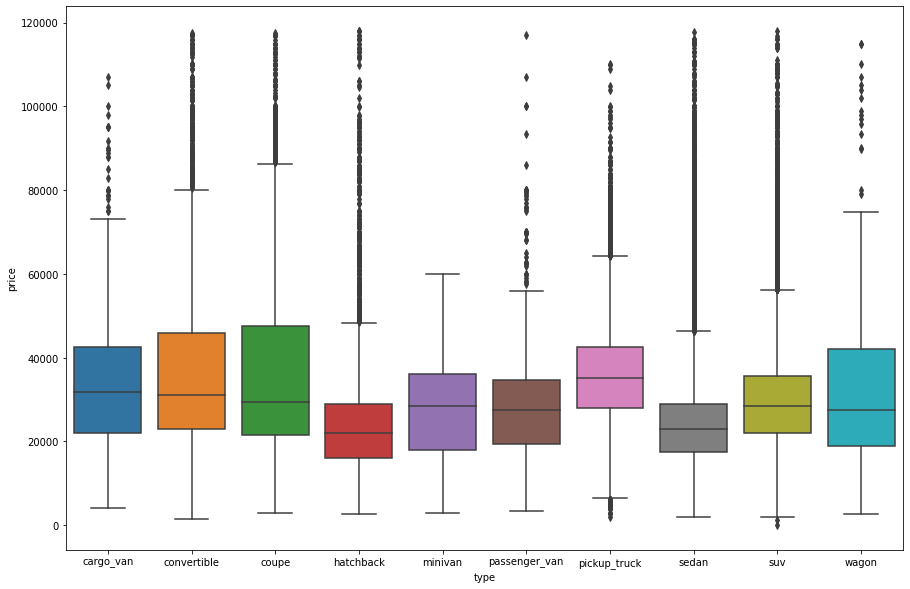

In [ ]:
# box plot of price by body-style
plt.figure(figsize = (15,10))
sns.boxplot(data = data[not_outliers], x = 'type', y='price')
plt.show()

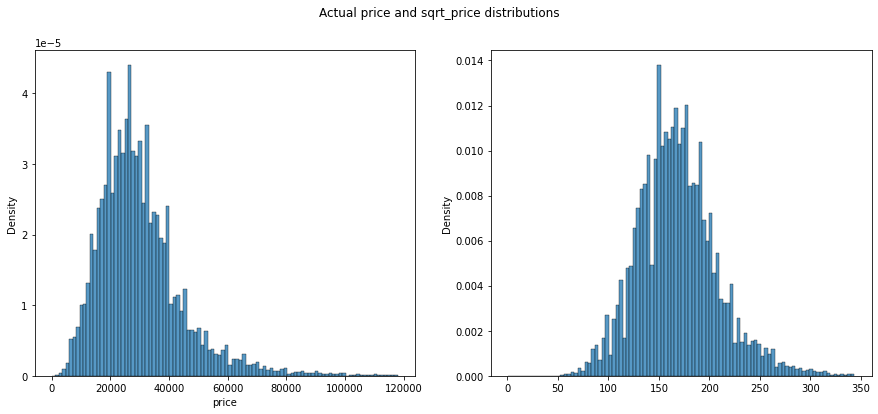

In [ ]:
# Density polts of actual (left) and sqrt price (right)
fig, axes = plt.subplots( 1, 2, figsize=(15, 6))
sns.histplot(data[not_outliers].price, stat='density', ax = axes[0], bins=100)
sns.histplot(np.sqrt(data[not_outliers].price.values), stat='density', ax = axes[1], bins=100)
fig.suptitle('Actual price and sqrt_price distributions')
plt.show()

If we wanted to make inferences from the model insead of making price prediction, it would be better to normalize the dependent feature with log or sqrt. 

In [ ]:
# see the impact of year and mileage for the specific models
def plot_prices(make = 'ford', model = 'focus'):
  subset = data[(data.make == make)&(data.model == model)]
  fig, axes = plt.subplots(1, 2, figsize=(15, 6))
  sns.scatterplot(data = subset, x = 'mileage', y = 'price', ax=axes[0])
  sns.scatterplot(data = subset, x = 'year', y = 'price', ax=axes[1])
  fig.suptitle(f'Prices as a function of mileage and year for {make}-{model}')
  plt.show()

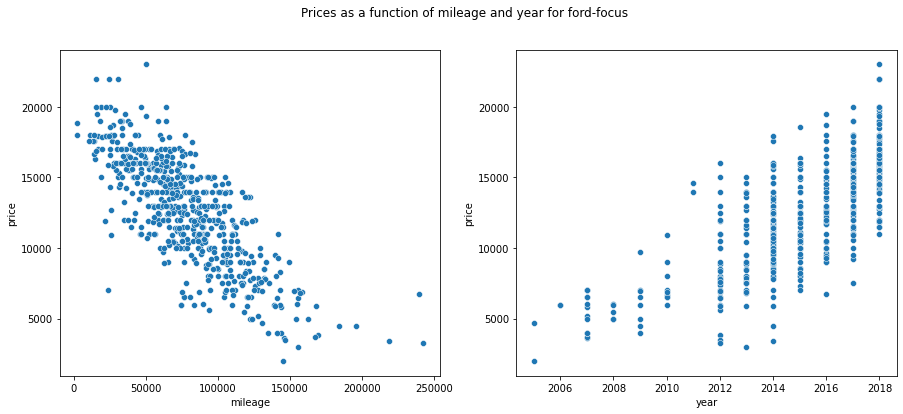

In [ ]:
# apply the above function for ford-focus
plot_prices(make = 'ford', model = 'focus')

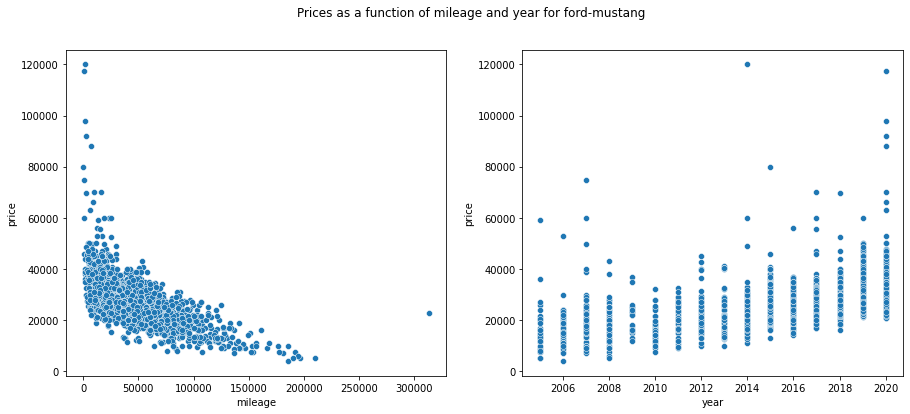

<Figure size 720x576 with 0 Axes>

In [ ]:
plot_prices(make = 'ford', model = 'mustang' )

# Price Regression, Tuning and Model Explainability

## Benchmark Model

In [ ]:
# get new feature
data['mile_per_year'] = data['mileage']/ (2022 - data['year']) #represents condition

# target and features
target = 'price'
features = ['type',	'model',	'make',	'year',	'mileage', 'mile_per_year', 'zip', 'rating', 'rating_count'] # ,'zip', 'rating', 'rating_count'

# convert to categorical
for col in features:
  if data[col].dtype == 'object' or col=='zip':
     data[col] = data[col].astype('category')

In [ ]:
# train test split
train_x, test_x, train_y, test_y = train_test_split(data[features], data[target], test_size = 0.15, shuffle = True, random_state = 122)
print(train_x.shape, test_x.shape)

(122446, 9) (21609, 9)


In [ ]:
# simple benchmark model
model = lgb.LGBMRegressor(max_depth = 15, n_estimators = 500, learning_rate = 0.05, eval_metric = 'mpae')
model.fit(train_x, train_y, eval_set=(test_x, test_y), verbose = 50)
print(f'\ntrain error {mean_absolute_percentage_error(train_y, model.predict(train_x))}')
print(f'test error {mean_absolute_percentage_error(test_y, model.predict(test_x))}')

[50]	valid_0's l2: 7.39837e+07
[100]	valid_0's l2: 5.67079e+07
[150]	valid_0's l2: 5.14944e+07
[200]	valid_0's l2: 4.92901e+07
[250]	valid_0's l2: 4.87953e+07
[300]	valid_0's l2: 4.85565e+07
[350]	valid_0's l2: 4.82211e+07
[400]	valid_0's l2: 4.79027e+07
[450]	valid_0's l2: 4.82632e+07
[500]	valid_0's l2: 4.85886e+07

train error 0.1625444237023468
test error 0.11031642428648744


## Bayesian Hyperparameter Optimization

In [ ]:
rkf = RepeatedKFold(n_splits=7, n_repeats=7, random_state=42)
dtrain = lgb.Dataset(data[features], label=data[target])

# We will track how many training rounds we needed for our best score.
# We will use that number of rounds later.
best_score = 0.2
train_rounds = 1000

# declare an objective function.
def objective(trial):
    # Specify a search space using distributions across plausible values of hyperparameters.
    param = {
        'boosting':'gbdt',
        'objective':'huber',
        'num_iterations': trial.suggest_int('num_iterations', 50, 1000),
        "boosting_type": "gbdt",     
        'metric': 'mape',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1)   ,      
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 3),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 3),
        'num_leaves': trial.suggest_int('num_leaves', 10, 60),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'seed': 1979
    }
    
    # Run LightGBM for the hyperparameter values
    lgbcv = lgb.cv(param,
                   dtrain,
                   folds = rkf,
                   verbose_eval = False,                   
                   early_stopping_rounds = 250,                   
                  )
                  #  num_boost_round=10000,                    
                  #  callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ]
    
    # we want the tuner to favor consistently good results
    cv_score = lgbcv['mape-mean'][-1] + lgbcv['mape-stdv'][-1] 
    if cv_score<best_score:
       best_score = cv_score
       train_rounds = len( list(lgbcv.values())[0] )
    # Return metric of interest
    return cv_score


In [ ]:
# We suppress information only outputs, because it takes up a lot of space
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# We search for 50 trials.
# We could do higher (n_trials=1000), to try 1000 hyperparameters chosen but it takes very long
study = optuna.create_study(direction='minimize')  
study.optimize(objective, n_trials = 50) 

###Visualizing the hyperparameter optimization


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

### Results of hyperparameter optimization


In [ ]:
print(study.best_params)

{'num_iterations': 864, 'learning_rate': 0.09970188425499209, 'lambda_l1': 0.000545308451880918, 'lambda_l2': 0.0007091579400160937, 'num_leaves': 28, 'feature_fraction': 0.6557267289495684, 'bagging_fraction': 0.5375273769598963, 'bagging_freq': 3, 'min_child_samples': 1}


## Tuned Model

In [ ]:
features = ['type', 'model', 'make', 'year', 'mileage', 'mile_per_year', 'zip']
cats = ['type', 'model', 'make', 'zip']

In [ ]:
train = lgb.Dataset(data = train_x[features], label = train_y, categorical_feature = cats) 
eval = lgb.Dataset(data = test_x[features], label = test_y, reference = train) 

params = {
     'objective':'regression_l1', 'boosting_type':'gbdt',
      'num_iterations': 4000, 'learning_rate': 0.04, 
      'drop_rate':0.33,
      'lambda_l1': 0.000545308451880918, 'lambda_l2': 0.0007091579400160937, 
      'num_leaves': 50, 'feature_fraction': 0.6557267289495684, 
      'bagging_fraction': 0.75,
      'metric': 'mape'
      }

model = lgb.train(params,
                    train,
                    valid_sets=[eval, train],
                    early_stopping_rounds=200, verbose_eval=500
                    )
print(f'\ntrain error {mean_absolute_percentage_error(train_y, model.predict(train_x[features]))}')
print(f'test error {mean_absolute_percentage_error(test_y, model.predict(test_x[features]))}')

Training until validation scores don't improve for 200 rounds.
[500]	training's mape: 0.145811	valid_0's mape: 0.0956138
[1000]	training's mape: 0.144114	valid_0's mape: 0.0952226
[1500]	training's mape: 0.141466	valid_0's mape: 0.0949379
Early stopping, best iteration is:
[1793]	training's mape: 0.1411	valid_0's mape: 0.0948805

train error 0.1411002762286639
test error 0.0948804994936482


Comparing with the benchmark performance, the tuning process helps us reduce the MAPE loss by almost 20%.

In [ ]:
# save the model
joblib.dump(model, 'final_model.pkl')

['final_model.pkl']

## Model explainability and Error Analysis

In [ ]:
# generate shap values for test set
test_x = test_x[features]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)

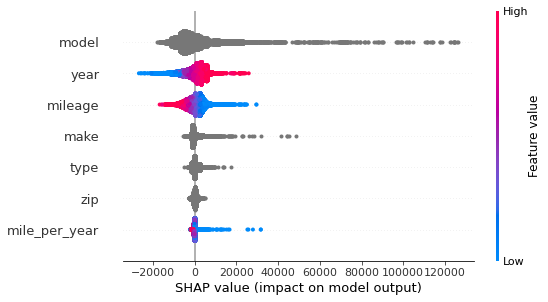

In [ ]:
# plot shap contributions
shap.summary_plot(shap_values, test_x)

Based on the contributions, Model, year and mileage are the most important factors as expected.

In [ ]:
# generate residual df
test_yhat = test_x.copy()
test_yhat['price']=test_y
yhat = 'pred_price'
y = 'price'
resid = 'r_price'
test_yhat[yhat] = model.predict(test_x)
test_yhat[resid] = np.abs(test_yhat[y]-test_yhat[yhat])/ test_yhat[y] # in terms of percentage of price

# add shap contributions to the data
cols_shap = [col+'_cont' for col in test_x.columns]
test_yhat[cols_shap] = shap_values
test_yhat = test_yhat.sort_values(by=resid, ascending=False).reset_index(drop=True)

# Define feature_values and shap values
shap_columns = cols_shap.copy()
ftr_columns = test_x.columns.copy()
shap_contribs = test_yhat[cols_shap]
ftr_values = test_yhat[ftr_columns]

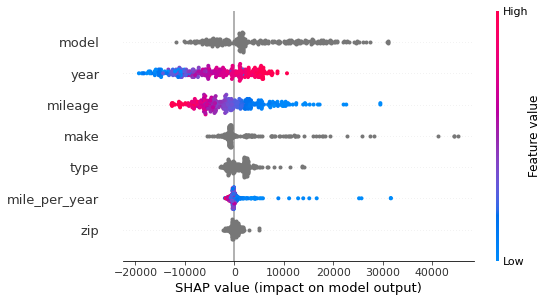

In [ ]:
# shap contributions for least accurate predictions
shap.summary_plot(shap_values = shap_contribs.values[0:300], features = ftr_values[0:300])

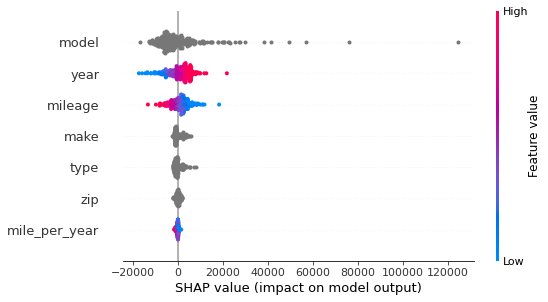

In [ ]:
# shap contributions for most accurate predictions
shap.summary_plot(shap_values = shap_contribs.values[-300:], features = ftr_values[-300:])

mile_per_year contributes to the least accurate predictions more than it does to the most accurate predictions. This feature may significantly affect the old cars that have not been driven too much or the new cars that have been driven relatively more in a bad way. Treating theese outliers seperately may improve the performance.

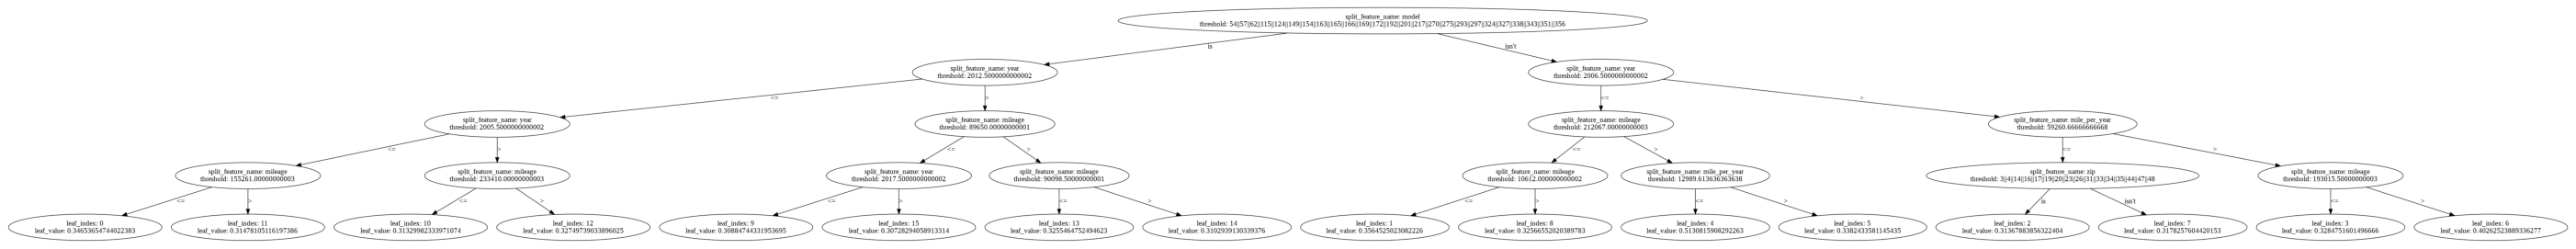

In [ ]:
# simple residual tree to see the root causes of large errors
cond = test_yhat[resid] > 0.2
xx=test_yhat.loc[cond,ftr_columns]
yy=test_yhat.loc[cond, resid]
tree=lgb.LGBMRegressor(random_state=0,max_depth=4, min_child_samples = 1,)
tree = tree.fit(xx, yy)
lgb.plot_tree(tree,figsize=(50,50))


Based on the surragate tree, the model does not perform very accurately for the cars with low mileage old cars or high mileage new cars. For instance, cars (outliers) in the dataset that are manufactured in 2005-2011 with low mileage or 2015+ model with high mileage. For these cars, the model is not able to make very accurate predictions, because mileage drives the prediction higher even though the car is very old. The model needs more data to be able to learn patterns like these.

In [ ]:
# least accurate predictions based on percentage error
test_yhat[features + [ y, yhat, resid]].head(500).sample(10)

,type,model,make,year,mileage,mile_per_year,zip,price,pred_price,r_price
248,passenger_van,odyssey,honda,2012.0,88464.0,8846.400000,19973,32228.0,17660.152459,0.452025
82,NaN,hhr,chevrolet,2009.0,167461.0,12881.615385,77087,3900.0,6321.714461,0.620952
352,pickup_truck,f_250,ford,2017.0,64361.0,12872.200000,99518,39988.0,56186.170563,0.405076
461,pickup_truck,colorado,chevrolet,2012.0,129720.0,12972.000000,18360,9997.0,13666.070787,0.367017
242,pickup_truck,f_150,ford,2020.0,58073.0,29036.500000,90004,64733.0,35303.520305,0.454629
19,sedan,impala,chevrolet,2006.0,102234.0,6389.625000,66023,3498.0,6795.950257,0.942810
170,coupe,civic,honda,2005.0,127814.0,7518.470588,1007,5000.0,7523.966404,0.504793
122,pickup_truck,f_150,ford,2020.0,34347.0,17173.500000,18360,91477.0,40661.408261,0.555501
111,sedan,maybach_s_650,mercedes_benz,2018.0,33708.0,8427.000000,75140,114990.0,50211.843942,0.563337
59,pickup_truck,silverado_2500,chevrolet,2019.0,109719.0,36573.000000,85009,27500.0,46235.065721,0.681275


In [ ]:
# most accurate predictions based on percentage error
test_yhat[features + [ y, yhat, resid]].tail(3000).sample(10)

,type,model,make,year,mileage,mile_per_year,zip,price,pred_price,r_price
21032,hatchback,440_gran_coupe,bmw,2019.0,23301.0,7767.000000,77087,37996.0,38112.399357,0.003063
19664,suv,rav4,toyota,2012.0,115210.0,11521.000000,47630,14995.0,15159.416893,0.010965
18694,sedan,civic,honda,2019.0,38268.0,12756.000000,90004,22988.0,23366.398852,0.016461
19116,pickup_truck,silverado_1500,chevrolet,2019.0,71248.0,23749.333333,55434,36338.0,36852.785014,0.014167
18838,sedan,civic,honda,2019.0,47386.0,15795.333333,92101,23698.0,23327.276488,0.015644
19725,sedan,civic,honda,2020.0,32890.0,16445.000000,94612,24899.0,25164.379254,0.010658
19264,passenger_van,sienna,toyota,2020.0,48681.0,24340.500000,55434,37700.0,37196.631981,0.013352
21394,passenger_van,sienna,toyota,2020.0,97568.0,48784.000000,11967,28500.0,28530.073092,0.001055
19067,sedan,camry,toyota,2020.0,65760.0,32880.000000,55434,23985.0,24329.886782,0.014379
19679,suv,cr_v,honda,2016.0,70203.0,11700.500000,85009,21990.0,21751.428376,0.010849


Below, we can confirm that it is more difficult to predict accurate price for the old cars. (with lower mileage given the years of usage)

In [ ]:
# average year for least accurate 1000 preds
print(f'average year for least acc 1000 preds - {int(np.median(test_yhat.year.values[:1000]))}')
# average year for most accurate 1000 preds
print(f'average year for most acc 1000 preds - {int(np.median(test_yhat.year.values[-1000:]))}')

average year for least acc 1000 preds - 2016
average year for most acc 1000 preds - 2018


In [ ]:
# average mileage for least acc 1000 preds
print(f'average mileage for least acc 1000 preds - {int(np.median(test_yhat.mileage.values[:1000]))}')
# average mileage for most acc 1000 preds
print(f'average mileage for most acc 1000 preds - {int(np.median(test_yhat.mileage.values[-1000:]))}')

average mileage for least acc 1000 preds - 73008
average mileage for most acc 1000 preds - 48685


In [ ]:
# average mileage for least acc 1000 preds
print(f'average mile_per_year for least acc 1000 preds - {int(np.median(test_yhat.mile_per_year.values[:1000]))}')
# average mileage for most acc 1000 preds
print(f'average mile_per_year for most acc 1000 preds - {int(np.median(test_yhat.mile_per_year.values[-1000:]))}')

average mile_per_year for least acc 1000 preds - 11574
average mile_per_year for most acc 1000 preds - 12743


## Visualizations for model performance for specific models

In [ ]:
model = joblib.load('final_model.pkl')

def plot_prices_preds(make = 'bmw', car_model = 'm5'):
  subset = test_yhat[(test_yhat.make == make)&(test_yhat.model == car_model)]
  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8), sharex = True, sharey = True)
  sns.scatterplot( x = subset['price'].values, y = model.predict(subset[features]), hue = np.array(subset.year.values).astype('int'), ax = ax1)
  sns.scatterplot( x = subset['price'].values, y = model.predict(subset[features]), hue = np.array(subset.mileage.values).astype('int'), ax = ax2)
  fig.suptitle(f'{make}-{car_model} Prices')
  ax1.set(xlabel='Actual price', ylabel='Predicted price')
  ax2.set(xlabel='Actual price', ylabel='Predicted price')
  plt.show()

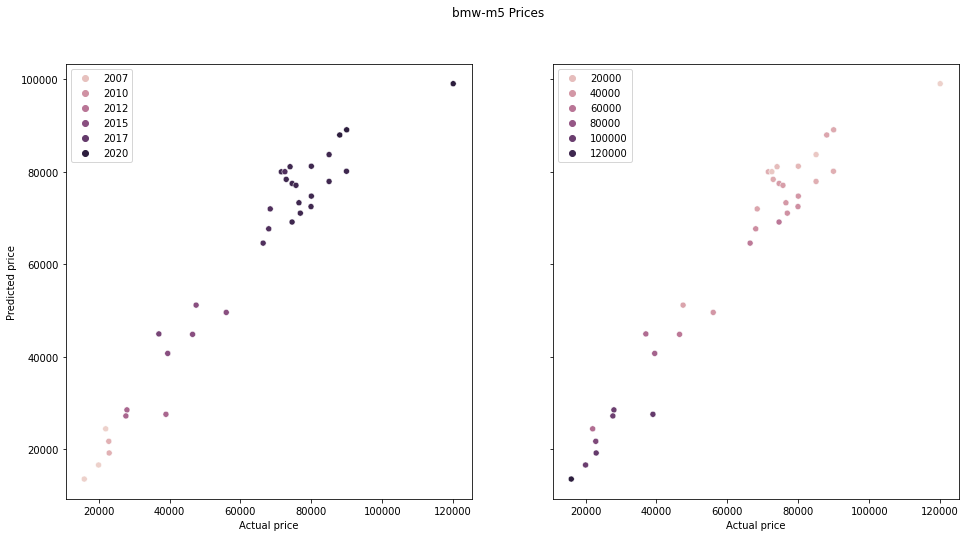

In [ ]:
# bmw m5
plot_prices_preds(make = 'bmw', car_model = 'm5')

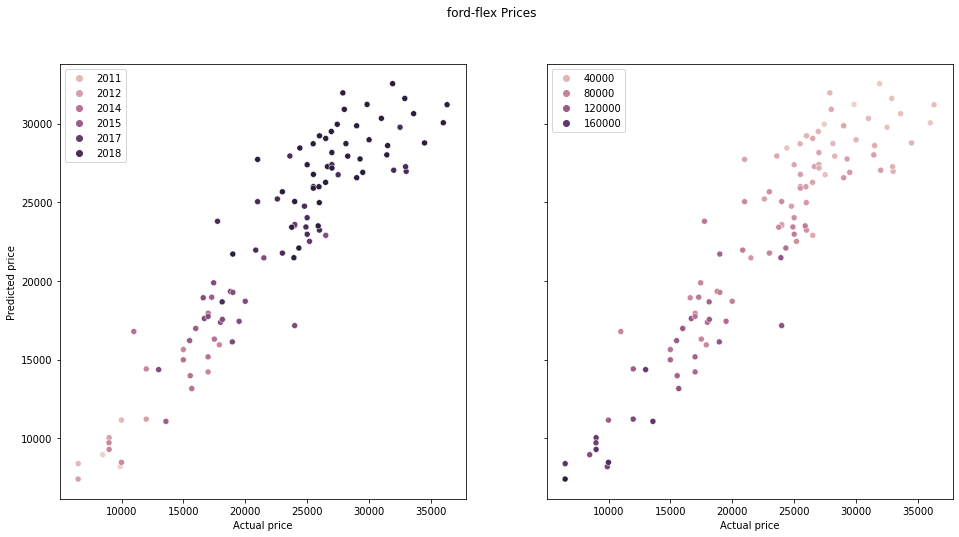

In [ ]:
# ford-flex
plot_prices_preds(make = 'ford', car_model = 'flex')

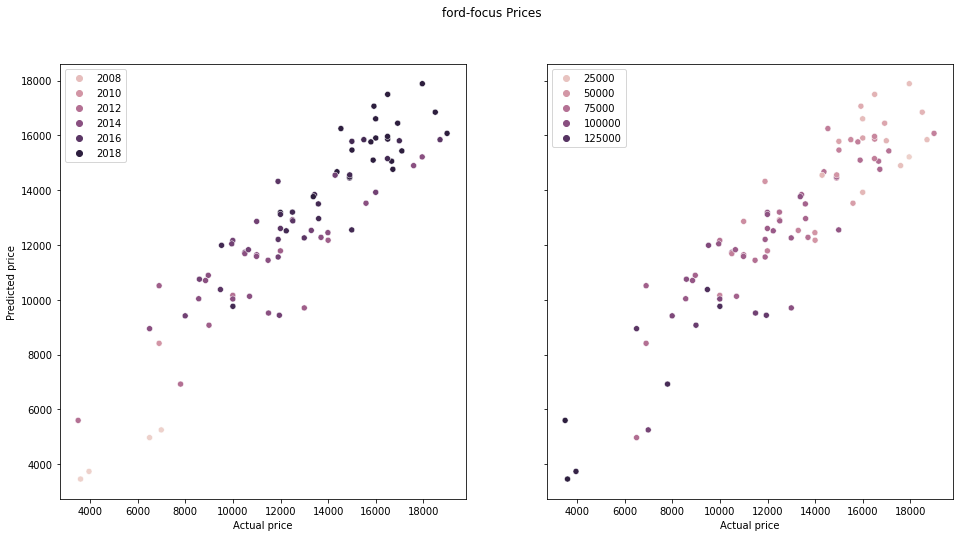

In [ ]:
# ford - mustang
plot_prices_preds(make = 'ford', car_model = 'focus')

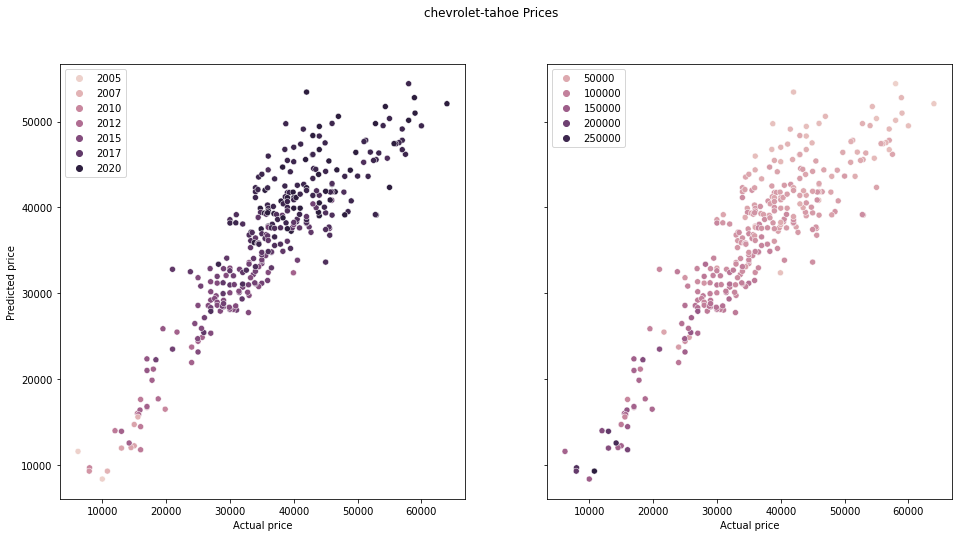

In [ ]:
# chevrolet tahoe
plot_prices_preds(make = 'chevrolet', car_model = 'tahoe')

We can see that the error variance is increasing as price increases. This is becuase of the fact that high-price (recent years) or luxury cars allows more and more options for car specs and custom add-ons which makes it hard to accurately estimate the price without having more data about car specs. 

## Plotly visualisations for the web app


In [ ]:
#pip install "kaleido==0.2.1"

In [ ]:
# make prediction for example values
values = ['sedan', 'e_class', 'mercedes_benz', float(2016), float(56850), float(9475), int(75140)]

def make_prediction(values):
  features = ['type', 'model', 'make', 'year', 'mileage', 'mile_per_year', 'zip']
  value_dict = {}
  for i in range(len(features)):
      value_dict[features[i]] = [values[i]]
  df = pd.DataFrame(value_dict)
  model = joblib.load('final_model.pkl')
  for column in ['type', 'model', 'make', 'zip']:
      df[column] = df[column].astype('category')
  prediction = int(model.predict(df)[0])
  return prediction

make_prediction(values)  

25942

In [ ]:
car_make = "bmw"
car_model = "m5"
subset = test_yhat
subset = subset[(subset.make == car_make)&(subset.model == car_model)]
fig = px.scatter(subset, x="price", y="pred_price", color = "mileage",
                 size = 'year', trendline="ols", 
                 title=f'Model Performance - Actual vs Estimated Price of {car_make}-{car_model} by mileage',
                 labels={
                     "price": "Price ($)",
                     "pred_price": "Predicted Prices ($)",
                     "mileage": "Mileage"
                 })
fig.show()

In [ ]:
# convert inputs into numpy array of required dtypes
  # example input : floats_str = 'sedan , bmw, m5,  2005 ,  152265  , 75252'
def floats_string_to_np_arr(floats_str):
  floats = [x.strip() for x in floats_str.split(',')]
  features = ['type', 'make', 'model', 'year', 'mileage', 'zip']
  value_dict = {}
  for i in range(len(features)):
    try: value_dict[features[i]] = [int(floats[i])]
    except: value_dict[features[i]] = [ floats[i] ]
  value_dict['mileage_per_year'] = [value_dict['mileage'][0]/(2022 - value_dict['year'][0])]
  return value_dict
  
# generate prediction and plot
def make_picture(new_values = values, training_data_path = 'cars_data.csv', model_path = 'final_model.pkl', output_file='predictions_pic.svg'):
  #inputs
  car_make = new_values['make'][0]
  car_model = new_values['model'][0]
  # load the data
  data = pd.read_csv(training_data_path)
  # create a subset for given model and make 
  subset = data.sample(100000)
  subset = subset[(subset.make == car_make)&(subset.model == car_model)]
  # get prediction        
  ## 1) convert inputs into suitable df format       
  features = ['type', 'model', 'make', 'year', 'mileage', 'zip']
  df = pd.DataFrame(new_values)[features]
  for column in ['type', 'model', 'make', 'zip']:
      df[column] = df[column].astype('category')
  ## 2) load the model and make prediction
  model = joblib.load(model_path)
  pred = model.predict(df)[0]

  # plot the prices as a function of mileage for the given model
  fig = px.scatter(
                  subset, x="year", y="price", color = "mileage", hover_name='type',
                  title=f'Price of {car_make}-{car_model} by mileage and year',
                  trendline = 'ols', trendline_options=dict(log_y=True)  # or trendline = 'lowess'
                  )
                  
  fig.add_trace(
                go.Scatter(
                          x = df['year'], y = [pred],
                          mode = "markers + text", name = '',
                          marker = {'color':'green', 'size':15} ,
                          text=[f"Estimated price = {str(round(pred/1000,1))+' k'}"],
                          textposition="top left",
                          )
              )
  fig.add_trace(
              go.Scatter(
                        x = df['year'], y = [pred],
                        mode = "markers", name = '',
                        marker = {'color':'green', 'size':15} ,
                        text=[f"Mileage = {round(values['mileage'][0]/1000,1)}k, body-style = {values['type'][0]}"],
                        textposition="top left", 
                        )
            )
  fig.update_layout(showlegend=False)

  fig.write_image(output_file, width=800)
  return fig

In [ ]:
floats_str = 'sedan , bmw, m5, 2015 , 50000 , 75252'
values = floats_string_to_np_arr(floats_str)
make_picture(new_values = values, output_file='predictions_pic.svg')